In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import os
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt

In [2]:
private_gap_file= 'output_v2/private_gap_charging_events.parquet'
private_charges_df = pd.read_parquet(private_gap_file)
len(private_charges_df)

372251

In [3]:


# ========== 2. 读取充电站信息 ==========
station_file = 'chargestation深圳.csv'
if not os.path.exists(station_file):
    # 尝试其他路径
    station_file = '../chargestation深圳.csv'
    if not os.path.exists(station_file):
        print(f"Error: Cannot find {station_file}")
        station_file = None



In [4]:

print(f"\nLoading charging stations from: {station_file}")
stations_df = pd.read_csv(station_file, encoding='utf-8')
print(f"Loaded {len(stations_df)} charging stations")
print(f"Columns: {list(stations_df.columns)}")

# 检查列名（可能是中文）
# 经度, 纬度 或 longitude, latitude
lon_col = None
lat_col = None

for col in stations_df.columns:
    if '经度' in col or 'longitude' in col.lower() or 'lon' in col.lower():
        lon_col = col
    if '纬度' in col or 'latitude' in col.lower() or 'lat' in col.lower():
        lat_col = col

if lon_col is None or lat_col is None:
    print("Warning: Cannot find longitude/latitude columns")
    print("Available columns:", list(stations_df.columns))
    # 尝试默认列名
    if '经度' in stations_df.columns and '纬度' in stations_df.columns:
        lon_col = '经度'
        lat_col = '纬度'
    else:
        print("Please check the CSV file format")
else:
    print(f"Using columns: {lon_col} (longitude), {lat_col} (latitude)")

    # 重命名为标准列名以便后续处理
    stations_df = stations_df.rename(columns={lon_col: 'longitude', lat_col: 'latitude'})

    # 过滤无效数据
    stations_df = stations_df.dropna(subset=['longitude', 'latitude'])
    stations_df = stations_df[
        (stations_df['longitude'] >= 113) & (stations_df['longitude'] <= 115) &
        (stations_df['latitude'] >= 22) & (stations_df['latitude'] <= 23)
    ].copy()

    print(f"Valid stations after filtering: {len(stations_df)}")




Loading charging stations from: ../chargestation深圳.csv
Loaded 4423 charging stations
Columns: ['名称', '大类', '中类', '经度', '纬度', '省份', '地级市', '区县']
Using columns: 经度 (longitude), 纬度 (latitude)
Valid stations after filtering: 4423


In [5]:
len(stations_df)

4423

In [7]:
stations_df.head()

,名称,大类,中类,longitude,latitude,省份,地级市,区县
0,杨梅坑专用停车场充电站,汽车相关,充电站,114.571256,22.544423,广东省,深圳市,龙岗区
1,开迈斯汽车公共充电站,汽车相关,充电站,114.568624,22.545040,广东省,深圳市,龙岗区
2,明天新能源公共充电站,汽车相关,充电站,114.518554,22.534409,广东省,深圳市,龙岗区
3,南方和顺汽车公共充电站,汽车相关,充电站,114.528781,22.529354,广东省,深圳市,龙岗区
4,云快充汽车公共充电站,汽车相关,充电站,114.518477,22.534385,广东省,深圳市,龙岗区


In [7]:
# ========== 3. 构建KDTree用于最近邻查询 ==========
station_coords = stations_df[['longitude', 'latitude']].to_numpy()
station_tree = cKDTree(station_coords)

# ========== 4. 计算每个私人充电事件到最近充电站的距离 ==========
if not private_charges_df.empty:
    # 确定私人充电事件的位置列
    private_lon_col = None
    private_lat_col = None

    for col in private_charges_df.columns:
        if 'lon' in col.lower() and 'start' in col.lower():
            private_lon_col = col
        if 'lat' in col.lower() and 'start' in col.lower():
            private_lat_col = col

    # 如果没有找到start_lon/start_lat，尝试其他可能的列名
    if private_lon_col is None:
        for col in private_charges_df.columns:
            if 'lon' in col.lower():
                private_lon_col = col
                break
    if private_lat_col is None:
        for col in private_charges_df.columns:
            if 'lat' in col.lower():
                private_lat_col = col
                break

    if private_lon_col is None or private_lat_col is None:
        print("\nError: Cannot find longitude/latitude columns in private charging events")
        print("Available columns:", list(private_charges_df.columns))
    else:
        print(f"\nUsing columns: {private_lon_col} (longitude), {private_lat_col} (latitude)")

        # 提取位置坐标
        private_coords = private_charges_df[[private_lon_col, private_lat_col]].to_numpy()

        # 查询最近充电站
        distances_deg, indices = station_tree.query(private_coords, k=1)

        # 将角度距离转换为米（粗略转换，适用于深圳地区）
        # 1度经度 ≈ 111320 * cos(纬度) 米
        # 1度纬度 ≈ 111320 米
        # 使用平均纬度进行转换
        avg_lat = private_charges_df[private_lat_col].mean()
        lat_factor = 111320  # 米/度
        lon_factor = 111320 * np.cos(np.radians(avg_lat))  # 米/度

        # 更精确的方法：使用Haversine公式计算实际距离
        def haversine_distance(lon1, lat1, lon2, lat2):
            """计算两点间的大圆距离（米）"""
            R = 6371000  # 地球半径（米）
            lon1_rad = np.radians(lon1)
            lat1_rad = np.radians(lat1)
            lon2_rad = np.radians(lon2)
            lat2_rad = np.radians(lat2)

            dlon = lon2_rad - lon1_rad
            dlat = lat2_rad - lat1_rad

            a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
            c = 2 * np.arcsin(np.sqrt(a))

            return R * c

        # 计算精确距离
        nearest_station_coords = station_coords[indices]
        distances_m = haversine_distance(
            private_charges_df[private_lon_col].values,
            private_charges_df[private_lat_col].values,
            nearest_station_coords[:, 0],
            nearest_station_coords[:, 1]
        )

        # 获取最近充电站的信息
        nearest_station_info = stations_df.iloc[indices].reset_index(drop=True)

        # 创建结果DataFrame
        result_df = private_charges_df.copy()
        result_df['nearest_station_index'] = indices
        result_df['nearest_station_name'] = nearest_station_info['名称'].values if '名称' in nearest_station_info.columns else None
        result_df['nearest_station_lon'] = nearest_station_info['longitude'].values
        result_df['nearest_station_lat'] = nearest_station_info['latitude'].values
        result_df['distance_to_nearest_station_m'] = distances_m
        result_df['distance_to_nearest_station_km'] = distances_m / 1000

        # ========== 5. 显示统计结果 ==========
        print("\n" + "=" * 60)
        print("Private Charging Events - Nearest Station Analysis")
        print("=" * 60)

        print(f"\nTotal private charging events: {len(result_df)}")
        print(f"\nDistance Statistics:")
        print(f"  Mean distance: {result_df['distance_to_nearest_station_km'].mean():.2f} km")
        print(f"  Median distance: {result_df['distance_to_nearest_station_km'].median():.2f} km")
        print(f"  Min distance: {result_df['distance_to_nearest_station_km'].min():.2f} km")
        print(f"  Max distance: {result_df['distance_to_nearest_station_km'].max():.2f} km")
        print(f"  Std distance: {result_df['distance_to_nearest_station_km'].std():.2f} km")

        # 统计距离分布
        print(f"\nDistance Distribution:")
        print(f"  < 0.3 km: {(result_df['distance_to_nearest_station_km'] < 0.3).sum()} ({(result_df['distance_to_nearest_station_km'] < 0.3).sum()/len(result_df)*100:.2f}%)")
        print(f"  0.3 - 0.5 km: {((result_df['distance_to_nearest_station_km'] >= 0.3) & (result_df['distance_to_nearest_station_km'] < 0.5)).sum()} ({((result_df['distance_to_nearest_station_km'] >= 0.3) & (result_df['distance_to_nearest_station_km'] < 0.5)).sum()/len(result_df)*100:.2f}%)")
        print(f"  0.5 - 1.0 km: {((result_df['distance_to_nearest_station_km'] >= 0.5) & (result_df['distance_to_nearest_station_km'] < 1.0)).sum()} ({((result_df['distance_to_nearest_station_km'] >= 0.5) & (result_df['distance_to_nearest_station_km'] < 1.0)).sum()/len(result_df)*100:.2f}%)")
        print(f"  >= 1.0 km: {(result_df['distance_to_nearest_station_km'] >= 1.0).sum()} ({(result_df['distance_to_nearest_station_km'] >= 1.0).sum()/len(result_df)*100:.2f}%)")

        # 显示前10个事件
        print(f"\nFirst 10 events with nearest station info:")
        display_cols = ['taxiid', 'start_time', private_lon_col, private_lat_col,
                       'nearest_station_name', 'distance_to_nearest_station_km']
        display_cols = [col for col in display_cols if col in result_df.columns]
        print(result_df[display_cols].head(10).to_string())

        # 保存结果（可选）
        output_file = 'private_charges_with_nearest_station.parquet'
        result_df.to_parquet(output_file, index=False)
        print(f"\nResults saved to: {output_file}")

        print("=" * 60)


Using columns: start_lon (longitude), start_lat (latitude)

Private Charging Events - Nearest Station Analysis

Total private charging events: 372251

Distance Statistics:
  Mean distance: 0.25 km
  Median distance: 0.19 km
  Min distance: 0.00 km
  Max distance: 7.79 km
  Std distance: 0.25 km

Distance Distribution:
  < 0.3 km: 262235 (70.45%)
  0.3 - 0.5 km: 71434 (19.19%)
  0.5 - 1.0 km: 35738 (9.60%)
  >= 1.0 km: 2844 (0.76%)

First 10 events with nearest station info:
      taxiid          start_time   start_lon  start_lat nearest_station_name  distance_to_nearest_station_km
0  UUUB0C0M7 2020-01-01 04:17:29  114.143974  22.557758           象前充汽车公共充电站                        0.177352
1  UUUB0C0M7 2020-01-01 16:18:31  114.143753  22.557638           象前充汽车公共充电站                        0.152227
2  UUUB0C0M7 2020-01-02 04:16:24  114.143974  22.557781           象前充汽车公共充电站                        0.177993
3  UUUB0C0M7 2020-01-02 16:09:34  114.143990  22.557774           象前充汽车公共充电站        

In [9]:
idx = result_df['distance_to_nearest_station_km']<0.5
new_df = result_df[idx]
new_df['nearest_station_name'].nunique()

763

In [10]:
stat_list = new_df['nearest_station_name'].unique().tolist()

In [11]:
stat_list

['象前充汽车公共充电站',
 '奥特能充电服务运营中心',
 '普天汽车充电站',
 '特来电公共充电站',
 '依威能源汽车公共充电站',
 '电动汽车公共充电站',
 '乐有家',
 '宝马公共充电站',
 '比亚迪公共充电站',
 '南方电网汽车公共充电站',
 '沙头角公共充电站',
 '小桔充电汽车公共充电站',
 '充电易科技充电站',
 '云快充汽车公共充电站',
 '里度充电',
 '南方和顺公共充电站',
 '南方和顺汽车公共充电站',
 '汇能新能源充电站',
 '宜停车站点',
 '汽车公共充电站',
 '昆仑网电汽车公共充电站',
 '依威能源汽车公共充电站合正锦园南区站',
 '万马爱充汽车公共充电站',
 '特斯拉水贝IBC超级公共充电站',
 '高速鹿上川路汽车公共充电站',
 'Shell汽车公共充电站',
 '行侠超级充电',
 '小鹏超级公共充电站',
 '清水河出租车公共充电站',
 '昆仑网电汽车充电站',
 '绿侠充电站',
 '深圳荔山御园一期公共充电站',
 '特斯拉超级公共充电站',
 '海岸城公共充电站',
 '依威能源汽车充电站',
 '富迪',
 '绿侠公共充电站',
 '深圳软件产业基地公共充电站',
 '体育公园-专用停车场充电站',
 '一能公共充电站',
 '云杉智慧深圳大学汽车公共充电站',
 '青禾南山马家龙艺园汽车公共充电站',
 '森通智达公共充电站',
 '普天充电站',
 '深圳供电局充电站',
 '比亚迪汽车公共充电站',
 '沃特玛创新联盟汽车公共充电站',
 '蔚景云汽车充电站',
 '广州电盟汽车公共充电站',
 '充电有道同心德公共充电站',
 '特来电汽车充电站',
 '普天宝路华公共充电站',
 '华南充电罗湖体育馆充电桩',
 '特来电汽车公共充电站',
 '贝岭居公共充电站',
 '充电有道汽车公共充电站',
 '蔚来能源汽车公共充电站',
 '云快充公共充电站',
 '普天公共充电站',
 '电动汽车充电站',
 '国家电网公共充电站',
 '南方和顺充电站',
 '奥特迅公共充电站',
 '华源电力汽车公共充电站',
 '大铲湾1号公共充电站',
 '西湖运输盛德龙新能源汽车公共充电站',
 '深圳供电局公共充电站',
 '奥特迅深圳福田体育公园公共充电站',
 '汽车

In [14]:
result_df.sort_values(['taxiid','start_time'])[:20]

,taxiid,start_time,end_time,gap_s,start_lon,start_lat,charge_type,nearest_station_index,nearest_station_name,nearest_station_lon,nearest_station_lat,distance_to_nearest_station_m,distance_to_nearest_station_km
0,UUUB0C0M7,2020-01-01 04:17:29,2020-01-01 05:48:13,5444.0,114.143974,22.557758,private_gap,1801,象前充汽车公共充电站,114.142300,22.557367,177.351840,0.177352
1,UUUB0C0M7,2020-01-01 16:18:31,2020-01-01 17:47:47,5356.0,114.143753,22.557638,private_gap,1801,象前充汽车公共充电站,114.142300,22.557367,152.227049,0.152227
2,UUUB0C0M7,2020-01-02 04:16:24,2020-01-02 05:41:39,5115.0,114.143974,22.557781,private_gap,1801,象前充汽车公共充电站,114.142300,22.557367,177.993366,0.177993
3,UUUB0C0M7,2020-01-02 16:09:34,2020-01-02 17:32:36,4982.0,114.143990,22.557774,private_gap,1801,象前充汽车公共充电站,114.142300,22.557367,179.291552,0.179292
4,UUUB0C0M7,2020-01-03 04:33:40,2020-01-03 05:44:59,4279.0,114.143890,22.557579,private_gap,1801,象前充汽车公共充电站,114.142300,22.557367,165.006212,0.165006
5,UUUB0C0M7,2020-01-03 16:01:51,2020-01-03 17:08:24,3993.0,114.143898,22.557587,private_gap,1801,象前充汽车公共充电站,114.142300,22.557367,165.904432,0.165904
6,UUUB0C0M7,2020-01-04 02:11:38,2020-01-04 02:52:55,2477.0,113.813133,22.623833,private_gap,4413,奥特能充电服务运营中心,113.813134,22.622891,104.712585,0.104713
7,UUUB0C0M7,2020-01-04 05:04:38,2020-01-04 06:45:40,6062.0,114.143761,22.557646,private_gap,1801,象前充汽车公共充电站,114.142300,22.557367,153.164500,0.153165
8,UUUB0C0M7,2020-01-04 16:20:01,2020-01-04 17:24:12,3851.0,114.143723,22.557545,private_gap,1801,象前充汽车公共充电站,114.142300,22.557367,147.407634,0.147408
9,UUUB0C0M7,2020-01-05 05:03:00,2020-01-05 06:27:21,5061.0,114.143776,22.557251,private_gap,1801,象前充汽车公共充电站,114.142300,22.557367,152.109571,0.152110


In [ ]:

from collections import Counter

# ========== 1. 读取私人充电事件数据 ==========
# 使用之前的结果文件，或者直接读取原始文件

if not private_charges_df.empty:
    # 确定位置列
    lon_col = None
    lat_col = None

    for col in private_charges_df.columns:
        if 'start_lon' in col.lower() or ('lon' in col.lower() and 'start' in col.lower()):
            lon_col = col
        if 'start_lat' in col.lower() or ('lat' in col.lower() and 'start' in col.lower()):
            lat_col = col

    # 如果没找到，尝试其他可能的列名
    if lon_col is None:
        for col in private_charges_df.columns:
            if 'lon' in col.lower():
                lon_col = col
                break
    if lat_col is None:
        for col in private_charges_df.columns:
            if 'lat' in col.lower():
                lat_col = col
                break

    if lon_col is None or lat_col is None:
        print("Error: Cannot find longitude/latitude columns")
        print("Available columns:", list(private_charges_df.columns))
    else:
        print(f"Using columns: {lon_col} (longitude), {lat_col} (latitude)")
        print(f"Total private charging events: {len(private_charges_df)}")

        # 提取坐标
        coords = private_charges_df[[lon_col, lat_col]].dropna().to_numpy()

        if len(coords) == 0:
            print("Error: No valid coordinates found")
        else:
            # ========== 2. 使用DBSCAN进行空间聚类 ==========
            # DBSCAN适合识别任意形状的聚集，不需要预先指定聚类数量
            # eps: 邻域半径（度），约等于多少米
            # 深圳地区：0.001度 ≈ 111米，0.01度 ≈ 1.1公里

            # 尝试不同的eps值
            eps_candidates = [0.001, 0.002, 0.005, 0.01]  # 约111m, 222m, 555m, 1.1km
            min_samples = 3  # 每个聚类最少点数

            print("\n" + "=" * 60)
            print("Spatial Clustering Analysis using DBSCAN")
            print("=" * 60)

            best_eps = None
            best_n_clusters = 0
            best_labels = None

            for eps in eps_candidates:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
                labels = dbscan.fit_predict(coords)
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # 排除噪声点
                n_noise = list(labels).count(-1)

                print(f"\neps={eps} (≈{eps*111:.0f}m):")
                print(f"  Number of clusters: {n_clusters}")
                print(f"  Noise points: {n_noise} ({n_noise/len(coords)*100:.2f}%)")
                print(f"  Clustered points: {len(coords)-n_noise} ({(len(coords)-n_noise)/len(coords)*100:.2f}%)")

                if n_clusters > best_n_clusters and n_noise/len(coords) < 0.5:  # 噪声点不超过50%
                    best_eps = eps
                    best_n_clusters = n_clusters
                    best_labels = labels

            if best_eps is None:
                best_eps = eps_candidates[0]
                dbscan = DBSCAN(eps=best_eps, min_samples=min_samples, metric='euclidean')
                best_labels = dbscan.fit_predict(coords)

            print(f"\nSelected eps={best_eps} (≈{best_eps*111:.0f}m)")

            # ========== 3. 分析聚类结果 ==========
            unique_labels = set(best_labels)
            n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
            n_noise = list(best_labels).count(-1)

            print(f"\nFinal Clustering Results:")
            print(f"  Total clusters: {n_clusters}")
            print(f"  Noise points: {n_noise}")
            print(f"  Clustered points: {len(coords) - n_noise}")

            # 统计每个聚类的信息
            cluster_info = []
            for label in unique_labels:
                if label == -1:
                    continue  # 跳过噪声点

                cluster_mask = best_labels == label
                cluster_points = coords[cluster_mask]
                cluster_size = len(cluster_points)

                # 计算聚类中心
                center_lon = cluster_points[:, 0].mean()
                center_lat = cluster_points[:, 1].mean()

                # 计算聚类半径（最远点到中心的距离）
                distances_to_center = np.sqrt(
                    (cluster_points[:, 0] - center_lon)**2 +
                    (cluster_points[:, 1] - center_lat)**2
                )
                radius_deg = distances_to_center.max()
                radius_m = radius_deg * 111320  # 粗略转换为米

                cluster_info.append({
                    'cluster_id': label,
                    'size': cluster_size,
                    'center_lon': center_lon,
                    'center_lat': center_lat,
                    'radius_deg': radius_deg,
                    'radius_m': radius_m
                })

            # 按大小排序
            cluster_info = sorted(cluster_info, key=lambda x: x['size'], reverse=True)

            print(f"\nTop 10 Largest Clusters:")
            print(f"{'Cluster ID':<12} {'Size':<8} {'Center (lon, lat)':<25} {'Radius (m)':<12}")
            print("-" * 70)
            for info in cluster_info[:10]:
                print(f"{info['cluster_id']:<12} {info['size']:<8} "
                      f"({info['center_lon']:.6f}, {info['center_lat']:.6f})  {info['radius_m']:.0f}")

            # ========== 4. 可视化 ==========
            fig, axes = plt.subplots(1, 2, figsize=(16, 7))

            # 4.1 原始分布图
            axes[0].scatter(coords[:, 0], coords[:, 1], s=1, alpha=0.3, c='gray', label='All events')
            axes[0].set_xlabel('Longitude')
            axes[0].set_ylabel('Latitude')
            axes[0].set_title(f'Original Distribution\n({len(coords)} events)')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)

            # 4.2 聚类结果图
            # 为每个聚类分配颜色
            colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
            color_map = {}
            for i, label in enumerate(sorted(unique_labels)):
                if label != -1:
                    color_map[label] = colors[i % len(colors)]

            # 绘制聚类点
            for label in unique_labels:
                if label == -1:
                    # 噪声点用灰色
                    mask = best_labels == label
                    axes[1].scatter(coords[mask, 0], coords[mask, 1],
                                   s=1, alpha=0.2, c='lightgray', label='Noise' if label == -1 else None)
                else:
                    mask = best_labels == label
                    axes[1].scatter(coords[mask, 0], coords[mask, 1],
                                   s=5, alpha=0.6, c=[color_map[label]],
                                   label=f'Cluster {label} (n={mask.sum()})' if mask.sum() >= 10 else None)

            # 标记聚类中心
            for info in cluster_info[:20]:  # 只显示前20个最大的聚类中心
                axes[1].plot(info['center_lon'], info['center_lat'],
                           'x', markersize=10, markeredgewidth=2,
                           color='red', label='Cluster centers' if info == cluster_info[0] else None)

            axes[1].set_xlabel('Longitude')
            axes[1].set_ylabel('Latitude')
            axes[1].set_title(f'DBSCAN Clustering Results\n(eps={best_eps:.4f}, {n_clusters} clusters, {n_noise} noise)')
            axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            axes[1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # ========== 5. 聚类大小分布 ==========
            cluster_sizes = [info['size'] for info in cluster_info]

            print(f"\nCluster Size Distribution:")
            print(f"  Mean cluster size: {np.mean(cluster_sizes):.2f}")
            print(f"  Median cluster size: {np.median(cluster_sizes):.2f}")
            print(f"  Largest cluster: {max(cluster_sizes)} events")
            print(f"  Smallest cluster: {min(cluster_sizes)} events")

            # 绘制聚类大小分布
            plt.figure(figsize=(10, 6))
            plt.hist(cluster_sizes, bins=min(50, len(cluster_sizes)), edgecolor='black', alpha=0.7)
            plt.xlabel('Cluster Size (number of events)')
            plt.ylabel('Number of Clusters')
            plt.title('Distribution of Cluster Sizes')
            plt.axvline(np.mean(cluster_sizes), color='red', linestyle='--',
                       label=f'Mean: {np.mean(cluster_sizes):.1f}')
            plt.axvline(np.median(cluster_sizes), color='blue', linestyle='--',
                       label=f'Median: {np.median(cluster_sizes):.1f}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

            # ========== 6. 保存聚类结果 ==========
            # 将聚类标签添加到原始数据
            result_with_clusters = private_charges_df.copy()
            # 只对有效坐标的行添加标签
            valid_mask = ~(private_charges_df[lon_col].isna() | private_charges_df[lat_col].isna())
            result_with_clusters.loc[valid_mask, 'cluster_id'] = best_labels
            result_with_clusters['cluster_id'] = result_with_clusters['cluster_id'].fillna(-2).astype(int)

            # 添加聚类中心信息
            cluster_centers_df = pd.DataFrame(cluster_info)
            cluster_centers_df.to_csv('private_charging_cluster_centers.csv', index=False)
            result_with_clusters.to_parquet('private_charges_with_clusters.parquet', index=False)

            print(f"\nResults saved:")
            print(f"  - private_charging_cluster_centers.csv")
            print(f"  - private_charges_with_clusters.parquet")

            print("\n" + "=" * 60)

            # ========== 7. 总结 ==========
            print("\nSummary:")
            if n_clusters > 0:
                total_clustered = sum(cluster_sizes)
                print(f"  {n_clusters} clusters identified containing {total_clustered} events ({total_clustered/len(coords)*100:.1f}%)")
                print(f"  {n_noise} events are scattered (not in clusters)")

                if len(cluster_info) > 0:
                    largest_cluster = cluster_info[0]
                    print(f"\n  Largest cluster:")
                    print(f"    - ID: {largest_cluster['cluster_id']}")
                    print(f"    - Size: {largest_cluster['size']} events")
                    print(f"    - Center: ({largest_cluster['center_lon']:.6f}, {largest_cluster['center_lat']:.6f})")
                    print(f"    - Radius: {largest_cluster['radius_m']:.0f} m")
            else:
                print("  No significant clusters found. Events are widely distributed.")

            print("=" * 60)

Using columns: start_lon (longitude), start_lat (latitude)
Total private charging events: 372251

Spatial Clustering Analysis using DBSCAN


In [7]:

import folium
from folium.plugins import MarkerCluster


if not private_charges_df.empty:
    # 确定位置列
    lon_col = None
    lat_col = None

    for col in private_charges_df.columns:
        if 'start_lon' in col.lower() or ('lon' in col.lower() and 'start' in col.lower()):
            lon_col = col
        if 'start_lat' in col.lower() or ('lat' in col.lower() and 'start' in col.lower()):
            lat_col = col

    if lon_col is None:
        for col in private_charges_df.columns:
            if 'lon' in col.lower():
                lon_col = col
                break
    if lat_col is None:
        for col in private_charges_df.columns:
            if 'lat' in col.lower():
                lat_col = col
                break

    if lon_col is None or lat_col is None:
        print("Error: Cannot find longitude/latitude columns")
        print("Available columns:", list(private_charges_df.columns))
    else:
        # 过滤有效坐标
        valid_df = private_charges_df.dropna(subset=[lon_col, lat_col]).copy()
        valid_df = valid_df[
            (valid_df[lon_col] >= 113) & (valid_df[lon_col] <= 115) &
            (valid_df[lat_col] >= 22) & (valid_df[lat_col] <= 23)
        ]

        if len(valid_df) == 0:
            print("Error: No valid coordinates found")
        else:
            print(f"Plotting {len(valid_df)} private charging events on Shenzhen map")

            # ========== 2. 计算地图中心 ==========
            center_lat = valid_df[lat_col].mean()
            center_lon = valid_df[lon_col].mean()

            # ========== 3. 创建地图 ==========
            m = folium.Map(
                location=[center_lat, center_lon],
                zoom_start=11,
                tiles='OpenStreetMap'
            )

            # ========== 4. 添加标记点 ==========
            # 使用MarkerCluster来避免过度拥挤
            marker_cluster = MarkerCluster(name='Private Charging Events').add_to(m)

            # 检查是否有聚类信息
            has_cluster = 'cluster_id' in valid_df.columns

            # 检查是否有距离信息
            has_distance = 'distance_to_nearest_station_km' in valid_df.columns

            # 为每个点添加标记
            for idx, row in valid_df.iterrows():
                # 准备popup信息
                popup_text = f"<b>Private Charging Event #{idx}</b><br>"
                popup_text += f"Taxi ID: {row.get('taxiid', 'N/A')}<br>"

                if 'start_time' in row:
                    popup_text += f"Start Time: {row['start_time']}<br>"
                if 'gap_s' in row or 'duration_s' in row:
                    duration = row.get('gap_s', row.get('duration_s', 'N/A'))
                    if duration != 'N/A':
                        duration_hours = duration / 3600
                        popup_text += f"Duration: {duration_hours:.2f} hours<br>"

                if has_cluster and row.get('cluster_id', -2) >= 0:
                    popup_text += f"Cluster ID: {row['cluster_id']}<br>"

                if has_distance:
                    popup_text += f"Distance to nearest station: {row['distance_to_nearest_station_km']:.2f} km<br>"

                popup_text += f"Location: ({row[lon_col]:.6f}, {row[lat_col]:.6f})"

                # 根据是否有聚类信息选择颜色
                if has_cluster and row.get('cluster_id', -2) >= 0:
                    # 有聚类的点用红色
                    color = 'red'
                    fill_color = 'red'
                else:
                    # 其他点用蓝色
                    color = 'blue'
                    fill_color = 'lightblue'

                # 添加圆形标记
                folium.CircleMarker(
                    location=[row[lat_col], row[lon_col]],
                    radius=3,
                    popup=folium.Popup(popup_text, max_width=300),
                    color=color,
                    fill=True,
                    fillColor=fill_color,
                    fillOpacity=0.6,
                    weight=1
                ).add_to(marker_cluster)

            # ========== 5. 添加图例 ==========
            legend_html = '''
            <div style="position: fixed;
                        bottom: 50px; left: 50px; width: 200px; height: 100px;
                        background-color: white; z-index:9999; font-size:14px;
                        border:2px solid grey; border-radius:5px; padding:10px">
            <h4 style="margin-top:0">Private Charging Events</h4>
            <p><span style="color:red;">●</span> Clustered</p>
            <p><span style="color:blue;">●</span> Scattered</p>
            <p>Total: ''' + str(len(valid_df)) + ''' events</p>
            </div>
            '''
            m.get_root().html.add_child(folium.Element(legend_html))

            # ========== 6. 保存地图 ==========
            output_file = 'private_charging_events_map.html'
            m.save(output_file)
            print(f"\nMap saved to: {output_file}")
            print(f"Open {output_file} in your browser to view the map")

            # 显示地图（如果在Jupyter notebook中）
            try:
                display(m)
            except:
                print("\nTo view the map, open the HTML file in your browser")

            print(f"\nMap Statistics:")
            print(f"  Total events plotted: {len(valid_df)}")
            print(f"  Center location: ({center_lat:.6f}, {center_lon:.6f})")
            if has_cluster:
                clustered = (valid_df['cluster_id'] >= 0).sum() if 'cluster_id' in valid_df.columns else 0
                print(f"  Clustered events: {clustered}")
                print(f"  Scattered events: {len(valid_df) - clustered}")

Plotting 372251 private charging events on Shenzhen map


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import MarkerCluster
import os

if not private_charges_df.empty:
    # 确定位置列
    lon_col = None
    lat_col = None

    for col in private_charges_df.columns:
        if 'start_lon' in col.lower() or ('lon' in col.lower() and 'start' in col.lower()):
            lon_col = col
        if 'start_lat' in col.lower() or ('lat' in col.lower() and 'start' in col.lower()):
            lat_col = col

    if lon_col is None:
        for col in private_charges_df.columns:
            if 'lon' in col.lower():
                lon_col = col
                break
    if lat_col is None:
        for col in private_charges_df.columns:
            if 'lat' in col.lower():
                lat_col = col
                break

    if lon_col is None or lat_col is None:
        print("Error: Cannot find longitude/latitude columns")
        print("Available columns:", list(private_charges_df.columns))
    else:
        # 过滤有效坐标
        valid_df = private_charges_df.dropna(subset=[lon_col, lat_col]).copy()
        valid_df = valid_df[
            (valid_df[lon_col] >= 113) & (valid_df[lon_col] <= 115) &
            (valid_df[lat_col] >= 22) & (valid_df[lat_col] <= 23)
        ]

        if len(valid_df) == 0:
            print("Error: No valid coordinates found")
        else:
            print(f"Processing {len(valid_df)} private charging events")

            # 提取坐标
            coords = valid_df[[lon_col, lat_col]].to_numpy()

            # ========== 2. 空间聚类 ==========
            # eps: 聚集半径（度），0.002度 ≈ 222米
            # min_samples: 最少点数，3个事件才算一个聚集
            eps = 0.002  # 约222米
            min_samples = 3

            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
            labels = dbscan.fit_predict(coords)

            # 统计聚类信息
            unique_labels = set(labels)
            n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
            n_noise = list(labels).count(-1)

            print(f"\nClustering Results:")
            print(f"  Total clusters: {n_clusters}")
            print(f"  Noise points: {n_noise}")
            print(f"  Clustered points: {len(coords) - n_noise}")

            # ========== 3. 计算每个聚类的中心 ==========
            cluster_centers = []

            for label in unique_labels:
                if label == -1:  # 跳过噪声点
                    continue

                cluster_mask = labels == label
                cluster_points = coords[cluster_mask]
                cluster_df = valid_df[cluster_mask]

                # 计算聚类中心（均值）
                center_lon = cluster_points[:, 0].mean()
                center_lat = cluster_points[:, 1].mean()

                # 统计信息
                n_events = len(cluster_points)
                n_vehicles = cluster_df['taxiid'].nunique() if 'taxiid' in cluster_df.columns else 0

                # 计算聚类半径（最远点到中心的距离）
                distances_to_center = np.sqrt(
                    (cluster_points[:, 0] - center_lon)**2 +
                    (cluster_points[:, 1] - center_lat)**2
                )
                radius_deg = distances_to_center.max()
                radius_m = radius_deg * 111320  # 转换为米

                cluster_centers.append({
                    'cluster_id': label,
                    'center_lon': center_lon,
                    'center_lat': center_lat,
                    'n_events': n_events,
                    'n_vehicles': n_vehicles,
                    'radius_m': radius_m
                })

            # 按事件数排序
            cluster_centers = sorted(cluster_centers, key=lambda x: x['n_events'], reverse=True)

            print(f"\nTop 10 Largest Clusters:")
            print(f"{'Cluster ID':<12} {'Events':<10} {'Vehicles':<10} {'Radius (m)':<12} {'Center (lon, lat)'}")
            print("-" * 80)
            for center in cluster_centers[:10]:
                print(f"{center['cluster_id']:<12} {center['n_events']:<10} {center['n_vehicles']:<10} "
                      f"{center['radius_m']:.0f}        ({center['center_lon']:.6f}, {center['center_lat']:.6f})")

            # ========== 4. 创建地图 ==========
            # 计算地图中心
            center_lat = valid_df[lat_col].mean()
            center_lon = valid_df[lon_col].mean()

            m = folium.Map(
                location=[center_lat, center_lon],
                zoom_start=11,
                tiles='OpenStreetMap'
            )

            # ========== 5. 添加所有事件点（浅色，小点） ==========
            # 使用MarkerCluster避免过度拥挤
            all_points_cluster = MarkerCluster(name='All Private Charging Events').add_to(m)

            for idx, row in valid_df.iterrows():
                folium.CircleMarker(
                    location=[row[lat_col], row[lon_col]],
                    radius=2,
                    popup=f"Event #{idx}<br>Taxi: {row.get('taxiid', 'N/A')}",
                    color='lightblue',
                    fill=True,
                    fillColor='lightblue',
                    fillOpacity=0.3,
                    weight=0.5
                ).add_to(all_points_cluster)

            # ========== 6. 添加聚集中心（大圆，不同颜色） ==========
            # 根据事件数设置颜色和大小
            for center in cluster_centers:
                # 根据事件数设置颜色
                if center['n_events'] >= 50:
                    color = 'red'
                    fill_color = 'darkred'
                elif center['n_events'] >= 20:
                    color = 'orange'
                    fill_color = 'darkorange'
                elif center['n_events'] >= 10:
                    color = 'yellow'
                    fill_color = 'gold'
                else:
                    color = 'green'
                    fill_color = 'lightgreen'

                # 根据事件数设置半径（地图上的圆大小）
                radius = min(15, max(5, center['n_events'] / 5))

                # 添加聚集中心标记
                folium.CircleMarker(
                    location=[center['center_lat'], center['center_lon']],
                    radius=radius,
                    popup=folium.Popup(
                        f"<b>Cluster Center #{center['cluster_id']}</b><br>"
                        f"Events: {center['n_events']}<br>"
                        f"Vehicles: {center['n_vehicles']}<br>"
                        f"Radius: {center['radius_m']:.0f} m<br>"
                        f"Location: ({center['center_lon']:.6f}, {center['center_lat']:.6f})",
                        max_width=300
                    ),
                    tooltip=f"Cluster {center['cluster_id']}: {center['n_events']} events, {center['n_vehicles']} vehicles",
                    color=color,
                    fill=True,
                    fillColor=fill_color,
                    fillOpacity=0.7,
                    weight=2
                ).add_to(m)

                # 添加聚类半径圆圈
                folium.Circle(
                    location=[center['center_lat'], center['center_lon']],
                    radius=center['radius_m'],
                    popup=f"Cluster {center['cluster_id']} radius: {center['radius_m']:.0f} m",
                    color=color,
                    fill=False,
                    weight=1,
                    opacity=0.5,
                    dashArray='5, 5'
                ).add_to(m)

            # ========== 7. 添加图例 ==========
            legend_html = f'''
            <div style="position: fixed;
                        bottom: 50px; left: 50px; width: 250px; height: 180px;
                        background-color: white; z-index:9999; font-size:14px;
                        border:2px solid grey; border-radius:5px; padding:10px">
            <h4 style="margin-top:0">Cluster Centers</h4>
            <p><span style="color:red;">●</span> Large (≥50 events)</p>
            <p><span style="color:orange;">●</span> Medium (20-49 events)</p>
            <p><span style="color:yellow;">●</span> Small (10-19 events)</p>
            <p><span style="color:green;">●</span> Tiny (3-9 events)</p>
            <hr>
            <p>Total clusters: {len(cluster_centers)}</p>
            <p>Total events: {len(valid_df)}</p>
            </div>
            '''
            m.get_root().html.add_child(folium.Element(legend_html))

            # ========== 8. 添加图层控制 ==========
            folium.LayerControl().add_to(m)

            # ========== 9. 保存地图 ==========
            output_file = 'private_charging_cluster_centers_map.html'
            m.save(output_file)
            print(f"\nMap saved to: {output_file}")
            print(f"Open {output_file} in your browser to view the map")

            # 显示地图（如果在Jupyter notebook中）
            try:
                display(m)
            except:
                print("\nTo view the map, open the HTML file in your browser")



Processing 372251 private charging events


Using columns: start_lon (longitude), start_lat (latitude), taxiid (taxiid)
Processing 372251 private charging events from 19316 vehicles

Stop Points Statistics per Vehicle

Total vehicles: 19316
Total private charging events: 372251

Stop Points Distribution:
  Mean: 5.61 points/vehicle
  Median: 5.00 points/vehicle
  Min: 1 points
  Max: 28 points
  Std: 2.73

Distribution by number of stop points:
Stop Points     Vehicles        Percentage     
---------------------------------------------
1               756             3.91%
2               1562            8.09%
3               2344            12.14%
4               2697            13.96%
5               2809            14.54%
6               2473            12.80%
7               2179            11.28%
8               1632            8.45%
9               1142            5.91%
10              748             3.87%
11              460             2.38%
12              259             1.34%
13              133             0.69%
14

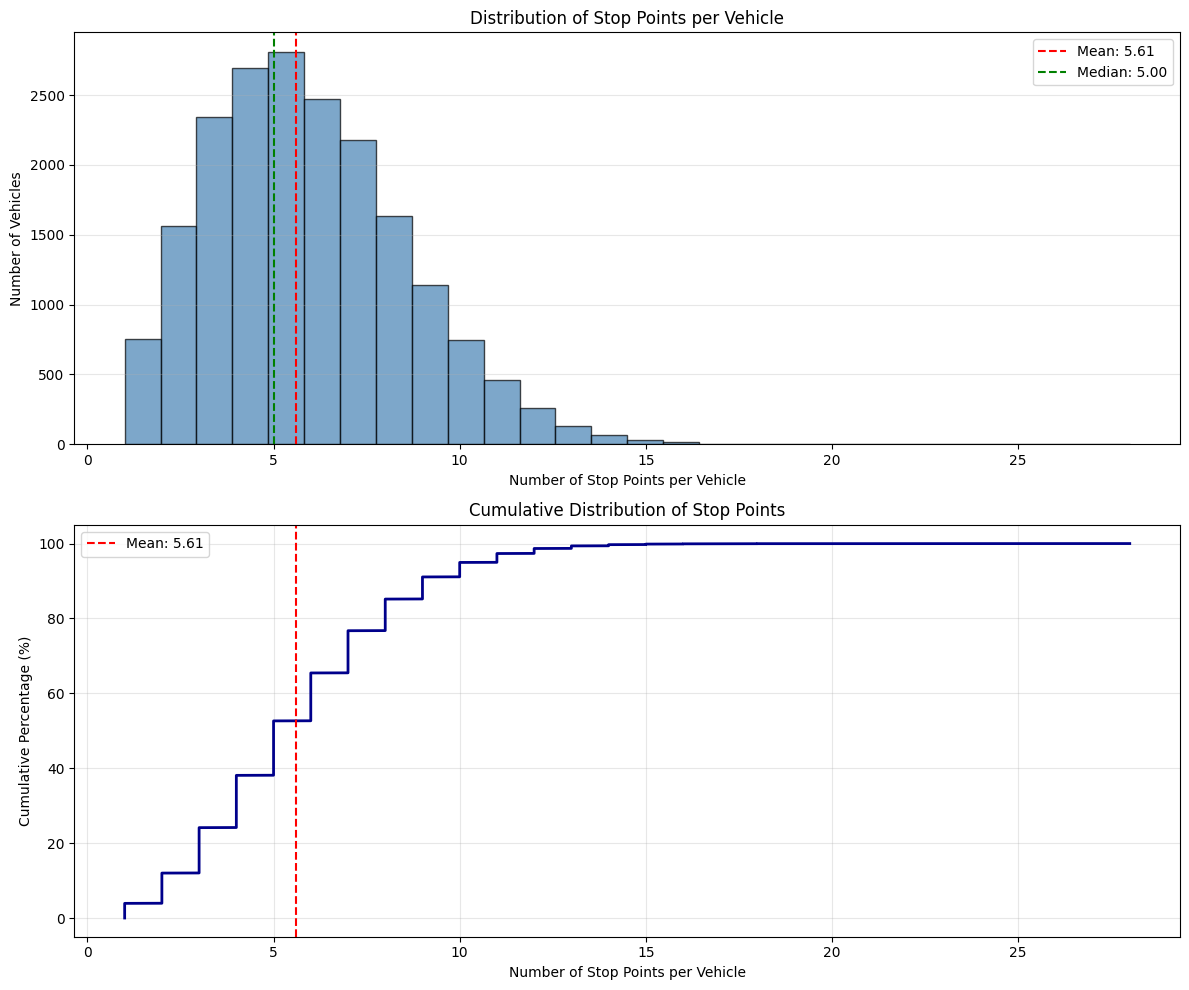


Results saved to: vehicle_stop_points_count.csv
Distribution statistics saved to: stop_points_distribution.txt


Additional Analysis:
  Vehicles with 1 stop point: 756 (3.91%)
  Vehicles with 2-3 stop points: 3906 (20.22%)
  Vehicles with 4-10 stop points: 7979 (41.31%)
  Vehicles with >10 stop points: 6675 (34.56%)


In [4]:


if not private_charges_df.empty:
    # 确定位置列和车辆ID列
    lon_col = None
    lat_col = None
    taxiid_col = None

    for col in private_charges_df.columns:
        if 'start_lon' in col.lower() or ('lon' in col.lower() and 'start' in col.lower()):
            lon_col = col
        if 'start_lat' in col.lower() or ('lat' in col.lower() and 'start' in col.lower()):
            lat_col = col
        if 'taxiid' in col.lower() or 'taxi_id' in col.lower():
            taxiid_col = col

    if lon_col is None:
        for col in private_charges_df.columns:
            if 'lon' in col.lower():
                lon_col = col
                break
    if lat_col is None:
        for col in private_charges_df.columns:
            if 'lat' in col.lower():
                lat_col = col
                break

    if lon_col is None or lat_col is None or taxiid_col is None:
        print("Error: Cannot find required columns")
        print("Available columns:", list(private_charges_df.columns))
    else:
        print(f"Using columns: {lon_col} (longitude), {lat_col} (latitude), {taxiid_col} (taxiid)")

        # 过滤有效数据
        valid_df = private_charges_df.dropna(subset=[lon_col, lat_col, taxiid_col]).copy()
        valid_df = valid_df[
            (valid_df[lon_col] >= 113) & (valid_df[lon_col] <= 115) &
            (valid_df[lat_col] >= 22) & (valid_df[lat_col] <= 23)
        ]

        if len(valid_df) == 0:
            print("Error: No valid data found")
        else:
            print(f"Processing {len(valid_df)} private charging events from {valid_df[taxiid_col].nunique()} vehicles")

            # ========== 2. 对每辆车进行位置聚类 ==========
            def haversine_distance(lon1, lat1, lon2, lat2):
                """计算两点间的大圆距离（米）"""
                R = 6371000  # 地球半径（米）
                lon1_rad = np.radians(lon1)
                lat1_rad = np.radians(lat1)
                lon2_rad = np.radians(lon2)
                lat2_rad = np.radians(lat2)

                dlon = lon2_rad - lon1_rad
                dlat = lat2_rad - lat1_rad

                a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
                c = 2 * np.arcsin(np.sqrt(a))

                return R * c

            # 自定义距离函数用于DBSCAN（将度转换为米）
            def custom_distance_matrix(coords):
                """计算坐标之间的距离矩阵（米）"""
                n = len(coords)
                distances = np.zeros((n, n))
                for i in range(n):
                    for j in range(i+1, n):
                        dist = haversine_distance(
                            coords[i, 0], coords[i, 1],
                            coords[j, 0], coords[j, 1]
                        )
                        distances[i, j] = dist
                        distances[j, i] = dist
                return distances

            # 对每辆车进行聚类
            vehicle_stop_points = []

            for taxiid, group in valid_df.groupby(taxiid_col):
                coords = group[[lon_col, lat_col]].to_numpy()

                if len(coords) < 2:

                    # 只有一个点，算作1个停留点
                    vehicle_stop_points.append({
                        'taxiid': taxiid,
                        'n_stop_points': 1,
                        'n_events': len(coords)
                    })
                    continue

                # 计算距离矩阵（米）
                dist_matrix = custom_distance_matrix(coords)

                # 使用DBSCAN，eps=200米，min_samples=1（每个点都可以是一个聚类）
                # 注意：DBSCAN需要距离矩阵，我们使用precomputed
                from sklearn.cluster import DBSCAN

                # 由于DBSCAN的precomputed需要对称矩阵，我们直接使用距离矩阵
                dbscan = DBSCAN(eps=1000, min_samples=1, metric='precomputed')
                labels = dbscan.fit_predict(dist_matrix)

                # 统计聚类数量（排除噪声点，但这里min_samples=1所以没有噪声）
                n_clusters = len(set(labels))

                vehicle_stop_points.append({
                    'taxiid': taxiid,
                    'n_stop_points': n_clusters,
                    'n_events': len(coords)
                })

            # 转换为DataFrame
            stop_points_df = pd.DataFrame(vehicle_stop_points)

            # ========== 3. 统计分布 ==========
            print("\n" + "=" * 60)
            print("Stop Points Statistics per Vehicle")
            print("=" * 60)

            print(f"\nTotal vehicles: {len(stop_points_df)}")
            print(f"Total private charging events: {stop_points_df['n_events'].sum()}")
            print(f"\nStop Points Distribution:")
            print(f"  Mean: {stop_points_df['n_stop_points'].mean():.2f} points/vehicle")
            print(f"  Median: {stop_points_df['n_stop_points'].median():.2f} points/vehicle")
            print(f"  Min: {stop_points_df['n_stop_points'].min()} points")
            print(f"  Max: {stop_points_df['n_stop_points'].max()} points")
            print(f"  Std: {stop_points_df['n_stop_points'].std():.2f}")

            # 统计不同停留点数量的车辆数
            stop_points_dist = stop_points_df['n_stop_points'].value_counts().sort_index()
            print(f"\nDistribution by number of stop points:")
            print(f"{'Stop Points':<15} {'Vehicles':<15} {'Percentage':<15}")
            print("-" * 45)
            for n_points, count in stop_points_dist.items():
                pct = count / len(stop_points_df) * 100
                print(f"{n_points:<15} {count:<15} {pct:.2f}%")

            # ========== 4. 可视化分布 ==========
            fig, axes = plt.subplots(2, 1, figsize=(12, 10))

            # 4.1 直方图
            axes[0].hist(stop_points_df['n_stop_points'], bins=min(50, stop_points_df['n_stop_points'].max()),
                        edgecolor='black', alpha=0.7, color='steelblue')
            axes[0].axvline(stop_points_df['n_stop_points'].mean(), color='red', linestyle='--',
                           label=f'Mean: {stop_points_df["n_stop_points"].mean():.2f}')
            axes[0].axvline(stop_points_df['n_stop_points'].median(), color='green', linestyle='--',
                           label=f'Median: {stop_points_df["n_stop_points"].median():.2f}')
            axes[0].set_xlabel('Number of Stop Points per Vehicle')
            axes[0].set_ylabel('Number of Vehicles')
            axes[0].set_title('Distribution of Stop Points per Vehicle')
            axes[0].legend()
            axes[0].grid(axis='y', alpha=0.3)

            # 4.2 累积分布
            sorted_points = np.sort(stop_points_df['n_stop_points'])
            cumulative = np.arange(1, len(sorted_points) + 1) / len(sorted_points) * 100
            axes[1].plot(sorted_points, cumulative, linewidth=2, color='darkblue')
            axes[1].axvline(stop_points_df['n_stop_points'].mean(), color='red', linestyle='--',
                           label=f'Mean: {stop_points_df["n_stop_points"].mean():.2f}')
            axes[1].set_xlabel('Number of Stop Points per Vehicle')
            axes[1].set_ylabel('Cumulative Percentage (%)')
            axes[1].set_title('Cumulative Distribution of Stop Points')
            axes[1].grid(True, alpha=0.3)
            axes[1].legend()

            plt.tight_layout()
            plt.show()

            # ========== 5. 保存结果 ==========
            stop_points_df.to_csv('vehicle_stop_points_count.csv', index=False)
            print(f"\nResults saved to: vehicle_stop_points_count.csv")

            # 保存分布统计
            with open('stop_points_distribution.txt', 'w') as f:
                f.write("Stop Points Distribution per Vehicle\n")
                f.write("=" * 60 + "\n\n")
                f.write(f"Total vehicles: {len(stop_points_df)}\n")
                f.write(f"Mean stop points: {stop_points_df['n_stop_points'].mean():.2f}\n")
                f.write(f"Median stop points: {stop_points_df['n_stop_points'].median():.2f}\n")
                f.write(f"Min: {stop_points_df['n_stop_points'].min()}\n")
                f.write(f"Max: {stop_points_df['n_stop_points'].max()}\n\n")
                f.write("Distribution:\n")
                for n_points, count in stop_points_dist.items():
                    pct = count / len(stop_points_df) * 100
                    f.write(f"  {n_points} points: {count} vehicles ({pct:.2f}%)\n")

            print(f"Distribution statistics saved to: stop_points_distribution.txt")

            print("\n" + "=" * 60)

            # ========== 6. 额外分析：停留点数量与事件数的关系 ==========
            print("\nAdditional Analysis:")
            print(f"  Vehicles with 1 stop point: {(stop_points_df['n_stop_points'] == 1).sum()} "
                  f"({(stop_points_df['n_stop_points'] == 1).sum()/len(stop_points_df)*100:.2f}%)")
            print(f"  Vehicles with 2-3 stop points: {((stop_points_df['n_stop_points'] >= 2) & (stop_points_df['n_stop_points'] <= 3)).sum()} "
                  f"({((stop_points_df['n_stop_points'] >= 2) & (stop_points_df['n_stop_points'] <= 3)).sum()/len(stop_points_df)*100:.2f}%)")
            print(f"  Vehicles with 4-10 stop points: {((stop_points_df['n_stop_points'] >= 4) & (stop_points_df['n_stop_points'] <= 6)).sum()} "
                  f"({((stop_points_df['n_stop_points'] >=4) & (stop_points_df['n_stop_points'] <= 6)).sum()/len(stop_points_df)*100:.2f}%)")
            print(f"  Vehicles with >10 stop points: {(stop_points_df['n_stop_points'] > 6).sum()} "
                  f"({(stop_points_df['n_stop_points'] > 6).sum()/len(stop_points_df)*100:.2f}%)")

            print("=" * 60)

In [ ]:
# ========== 方法1: 使用高德地图API获取充电站详细信息 ==========
# 需要先申请高德地图API Key: https://console.amap.com/dev/key/app
# 免费额度：每天30万次调用

import requests
import time
import json

def get_amap_poi_info(lon, lat, name, api_key):
    """
    通过高德地图API获取POI详细信息
    """
    # 高德地图逆地理编码 + POI搜索
    url = "https://restapi.amap.com/v3/geocode/regeo"
    params = {
        'key': api_key,
        'location': f'{lon},{lat}',
        'radius': 1000,  # 搜索半径1000米
        'extensions': 'all',
        'output': 'json'
    }
    
    try:
        response = requests.get(url, params=params, timeout=5)
        data = response.json()
        
        if data.get('status') == '1':
            # 获取附近POI信息
            pois = data.get('regeocode', {}).get('pois', [])
            
            # 尝试匹配充电站名称
            best_match = None
            for poi in pois:
                if '充电' in poi.get('name', '') or '充电' in poi.get('type', ''):
                    # 计算距离
                    poi_location = poi.get('location', '').split(',')
                    if len(poi_location) == 2:
                        poi_lon, poi_lat = float(poi_location[0]), float(poi_location[1])
                        distance = ((lon - poi_lon)**2 + (lat - poi_lat)**2)**0.5 * 111000  # 粗略转换为米
                        if distance < 500:  # 500米内
                            if best_match is None or distance < best_match.get('distance', 999999):
                                best_match = {
                                    'name': poi.get('name', ''),
                                    'address': poi.get('address', ''),
                                    'type': poi.get('type', ''),
                                    'tel': poi.get('tel', ''),
                                    'distance': distance,
                                    'business_area': poi.get('business_area', ''),
                                    'location': poi.get('location', '')
                                }
            
            return best_match if best_match else {
                'name': name,
                'address': data.get('regeocode', {}).get('formatted_address', ''),
                'type': '',
                'tel': '',
                'distance': 0,
                'business_area': '',
                'location': f'{lon},{lat}'
            }
        else:
            print(f"API Error: {data.get('info', 'Unknown error')}")
            return None
    except Exception as e:
        print(f"Error fetching data for {name}: {e}")
        return None

# 使用示例（需要替换为你的API Key）
# AMAP_API_KEY = 'your_amap_api_key_here'
# 
# # 批量获取（注意API调用频率限制）
# enhanced_stations = []
# for idx, row in stations_df.head(10).iterrows():  # 先测试前10个
#     info = get_amap_poi_info(row['longitude'], row['latitude'], row['名称'], AMAP_API_KEY)
#     if info:
#         enhanced_stations.append({
#             **row.to_dict(),
#             '详细地址': info.get('address', ''),
#             '联系电话': info.get('tel', ''),
#             'POI类型': info.get('type', ''),
#             '商圈': info.get('business_area', '')
#         })
#     time.sleep(0.1)  # 避免请求过快
# 
# enhanced_df = pd.DataFrame(enhanced_stations)
# print(enhanced_df)


In [ ]:
# ========== 方法2: 使用高德地图POI搜索API（更精确） ==========
# 直接搜索充电站POI，信息更准确

def search_amap_charging_station(lon, lat, name, api_key, radius=500):
    """
    搜索指定位置附近的充电站POI
    """
    url = "https://restapi.amap.com/v3/place/around"
    params = {
        'key': api_key,
        'location': f'{lon},{lat}',
        'keywords': '充电站|充电桩',
        'types': '030000',  # 汽车服务相关
        'radius': radius,
        'offset': 20,
        'page': 1,
        'extensions': 'all',
        'output': 'json'
    }
    
    try:
        response = requests.get(url, params=params, timeout=5)
        data = response.json()
        
        if data.get('status') == '1' and data.get('pois'):
            pois = data['pois']
            # 找到最近的匹配项
            best_match = None
            min_distance = float('inf')
            
            for poi in pois:
                poi_location = poi.get('location', '').split(',')
                if len(poi_location) == 2:
                    poi_lon, poi_lat = float(poi_location[0]), float(poi_location[1])
                    distance = ((lon - poi_lon)**2 + (lat - poi_lat)**2)**0.5 * 111000
                    
                    if distance < min_distance and distance < radius:
                        min_distance = distance
                        best_match = {
                            'name': poi.get('name', ''),
                            'address': poi.get('address', ''),
                            'province': poi.get('pname', ''),
                            'city': poi.get('cityname', ''),
                            'district': poi.get('adname', ''),
                            'type': poi.get('type', ''),
                            'tel': poi.get('tel', ''),
                            'business_area': poi.get('business_area', ''),
                            'distance': distance,
                            'location': poi.get('location', ''),
                            'id': poi.get('id', '')
                        }
            
            return best_match
        else:
            return None
    except Exception as e:
        print(f"Error: {e}")
        return None

# 使用示例
# AMAP_API_KEY = 'your_amap_api_key_here'
# 
# # 批量获取
# enhanced_data = []
# for idx, row in stations_df.head(10).iterrows():
#     result = search_amap_charging_station(
#         row['longitude'], 
#         row['latitude'], 
#         row['名称'], 
#         AMAP_API_KEY
#     )
#     if result:
#         enhanced_data.append({**row.to_dict(), **result})
#     time.sleep(0.1)
# 
# enhanced_df = pd.DataFrame(enhanced_data)


In [ ]:
# ========== 方法3: 使用OpenStreetMap/Nominatim（免费，无需API Key） ==========
# 注意：国内数据可能不如高德/百度详细

def get_osm_info(lon, lat, name):
    """
    使用Nominatim获取位置信息（免费，但请求频率有限制）
    """
    url = "https://nominatim.openstreetmap.org/reverse"
    params = {
        'lat': lat,
        'lon': lon,
        'format': 'json',
        'addressdetails': 1,
        'zoom': 18
    }
    headers = {
        'User-Agent': 'ChargingStationInfoCollector/1.0'  # 必须设置User-Agent
    }
    
    try:
        response = requests.get(url, params=params, headers=headers, timeout=10)
        data = response.json()
        
        if 'address' in data:
            address = data['address']
            return {
                'osm_name': data.get('display_name', ''),
                'road': address.get('road', ''),
                'suburb': address.get('suburb', ''),
                'city': address.get('city') or address.get('town') or address.get('village', ''),
                'postcode': address.get('postcode', ''),
                'country': address.get('country', ''),
                'osm_type': data.get('type', ''),
                'osm_id': data.get('osm_id', '')
            }
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None

# 使用示例（注意：有请求频率限制，建议添加延迟）
# enhanced_data = []
# for idx, row in stations_df.head(5).iterrows():  # 先测试少量数据
#     info = get_osm_info(row['longitude'], row['latitude'], row['名称'])
#     if info:
#         enhanced_data.append({**row.to_dict(), **info})
#     time.sleep(1)  # Nominatim要求至少1秒间隔
# 
# enhanced_df = pd.DataFrame(enhanced_data)


In [ ]:
# ========== 批量获取充电站详细信息（推荐使用方法2） ==========
# 完整示例：批量获取所有充电站的详细信息并保存

def batch_enhance_stations(stations_df, api_key, method='amap_poi', batch_size=100, delay=0.1):
    """
    批量获取充电站详细信息
    
    参数:
    - stations_df: 包含longitude, latitude, 名称的DataFrame
    - api_key: 高德地图API Key（如果使用方法1或2）
    - method: 'amap_poi' 或 'osm'
    - batch_size: 每批处理数量
    - delay: 请求间隔（秒）
    """
    enhanced_data = []
    total = len(stations_df)
    
    print(f"开始批量获取 {total} 个充电站的信息...")
    print(f"方法: {method}, 批次大小: {batch_size}, 延迟: {delay}秒")
    
    for idx, row in stations_df.iterrows():
        try:
            if method == 'amap_poi':
                result = search_amap_charging_station(
                    row['longitude'], 
                    row['latitude'], 
                    row['名称'], 
                    api_key
                )
            elif method == 'osm':
                result = get_osm_info(row['longitude'], row['latitude'], row['名称'])
            else:
                result = None
            
            if result:
                enhanced_data.append({**row.to_dict(), **result})
            else:
                # 即使API没返回，也保留原始数据
                enhanced_data.append(row.to_dict())
            
            # 进度显示
            if (idx + 1) % batch_size == 0:
                print(f"已处理: {idx + 1}/{total} ({100*(idx+1)/total:.1f}%)")
            
            time.sleep(delay)
            
        except Exception as e:
            print(f"处理第 {idx} 行时出错: {e}")
            enhanced_data.append(row.to_dict())  # 保留原始数据
            continue
    
    enhanced_df = pd.DataFrame(enhanced_data)
    print(f"\n完成！成功获取 {len(enhanced_data)} 条记录")
    return enhanced_df

# 使用示例：
# 1. 先申请高德地图API Key: https://console.amap.com/dev/key/app
# 2. 替换下面的API Key
# AMAP_API_KEY = 'your_amap_api_key_here'
# 
# # 先测试少量数据
# test_df = stations_df.head(10)
# enhanced_test = batch_enhance_stations(test_df, AMAP_API_KEY, method='amap_poi')
# print(enhanced_test.head())
# 
# # 如果测试成功，再批量处理全部数据
# # enhanced_all = batch_enhance_stations(stations_df, AMAP_API_KEY, method='amap_poi')
# # enhanced_all.to_csv('chargestation深圳_enhanced.csv', index=False, encoding='utf-8-sig')
# # enhanced_all.to_parquet('chargestation深圳_enhanced.parquet', index=False)


## 获取充电站详细信息的方法总结

### 方法对比：

1. **高德地图API（推荐）**
   - ✅ 信息最全面（地址、电话、商圈、POI类型等）
   - ✅ 国内数据最准确
   - ✅ 免费额度：每天30万次
   - ⚠️ 需要申请API Key: https://console.amap.com/dev/key/app
   - 📝 使用方法2（POI搜索）更精确

2. **OpenStreetMap/Nominatim**
   - ✅ 完全免费，无需API Key
   - ✅ 全球数据
   - ❌ 国内数据不如高德详细
   - ⚠️ 请求频率限制：1秒/次

3. **其他可选方案**
   - 百度地图API：类似高德，需要API Key
   - 腾讯地图API：类似高德，需要API Key

### 可以获取的额外信息：
- 详细地址（街道、门牌号）
- 联系电话
- 商圈信息
- POI类型分类
- 行政区划（省市区）
- 邮政编码
- 营业时间（部分API提供）
- 评分/评价（部分API提供）

### 使用建议：
1. 优先使用高德地图API（方法2）
2. 先测试少量数据（10-20个站）
3. 注意API调用频率限制
4. 保存结果到CSV或Parquet文件
